<a href="https://colab.research.google.com/github/v1t3ls0n/ml_intro_course_mmn11/blob/main/notebooks/guyvitelson_mmn11_ml_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ממן 11 - מבוא ללמידה חישובית - סמסטר 2025ב - גיא ויטלזון 203379706

##**If you run this within Google Collab, Dont Worry!**
all the missing python files/directories/modules will be automatically feteched from my github repository

**My GitHub Profile** : https://github.com/v1t3ls0n

**The Repository:** https://github.com/v1t3ls0n/ml_intro_course_mmn11

**Student ID:** 203379706

## Fetch Resources


### External Code Imports (pip packages)

In [1]:
import os
import shutil
import sys
import logging
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import time
import pandas as pd


### Fetch Missing Files For Google Colab Env

In [2]:

# %%capture run_output
# %matplotlib inline

if sys.platform != 'win32': # check if we are running on google collab
  repo_url = "https://github.com/v1t3ls0n/ml_intro_course_mmn11"
  repo_name = "ml_intro_course_mmn11"
  from tqdm.notebook import tqdm # type: ignore


  # Clone the repository if it doesn't exist
  if not os.path.exists(repo_name):
    os.system(f"git clone {repo_url}")

  # Construct the path to the repository directory
  repo_path = os.path.join(os.getcwd(), repo_name)

  # Add the repository directory to the Python path
  if repo_path not in sys.path:
    sys.path.insert(0, repo_path)

  # --- Extract 'core' and 'notebooks' directories ---
  def extract_directories(source_dir, destination_dir, dir_names):
      for dir_name in dir_names:
          source_path = os.path.join(source_dir, dir_name)
          destination_path = os.path.join(destination_dir, dir_name)
          if os.path.exists(source_path):
              shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

  destination_path = "."
  # Extract the directories
  extract_directories(repo_path, destination_path, ["core"])
  project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
  sys.path.insert(0, project_root)
  if os.path.exists("ml_intro_course_mmn11"):
    shutil.rmtree("ml_intro_course_mmn11")
  if os.path.exists("sample_data"):
    shutil.rmtree("sample_data")
else:
  from tqdm import tqdm  # type: ignore
  current_dir = os.getcwd()  # Current working directory
  project_root = os.path.abspath(os.path.join(current_dir, '..'))  # Root directory of the project
  sys.path.insert(0, project_root)


### Internal Code Imports (original code)

In [3]:

# ========== Internal Code Imports ==========

#Logger
from core.logger.config import logger

# Data Preprocessing
from core.data.mnist_loader import load_mnist
from core.data.data_preprocessing import preprocess_data

# Models
from core.models.perceptron.multi_class_perceptron import MultiClassPerceptron
from core.models.logistic_regression.softmax_lregression import SoftmaxRegression
from core.models.linear_regression.linear_regression import  LinearRegression

# Performance & Plotting
from core.analysis.evaluation_functions import (
    evaluate_model,
    aggregate_iteration_losses,
    aggregate_iteration_losses_softmax
)

from core.analysis.plotting import (
    plot_confusion_matrix_annotated,
    plot_error_curves,
    plot_accuracy_vs_max_iter,
    plot_runtime_vs_max_iter,
    plot_performance_summary_extended,
    plot_train_curves_three_models,
    plot_metric_vs_learning_rate,
    plot_accuracy_vs_max_iter_4models,
    plot_runtime_vs_max_iter_4models,
    plot_accuracy_vs_runtime,
    plot_performance_summary_extended_by_runtime,
    plot_performance_summary_4models_by_runtime,
    plot_accuracy_vs_runtime_4models
)

logger = logging.getLogger("MyGlobalLogger") # configured in core/logger/config.py


# Overview



## MNIST Digit Classification Report

### Approach

#### Data Preprocessing
The MNIST dataset was prepared by:
- Splitting into training (60,000 samples) and test sets (10,000 samples).
- Normalizing pixel values to the [0,1] range.
- Flattening images into vectors (784 pixels plus 1 bias term).
- Encoding labels into one-hot vectors.

#### Model Implementation
- **Multi-Class Perceptron:**
  - One-vs-all strategy implemented with standard Perceptron and Pocket Perceptron algorithms.
- **Softmax Regression:**
  - Implemented using cross-entropy loss and adaptive learning rates (AdaGrad).
  - Included early stopping based on loss improvement.
- **Linear Regression:**
  - Utilized mean squared error loss with gradient descent.
  - AdaGrad adaptive learning rate and early stopping were applied.

### Results

- **Accuracy:**
  - Softmax Regression achieved the highest accuracy.
  - Multi-class Pocket Perceptron showed good performance, surpassing standard Perceptron.
  - Linear Regression exhibited relatively lower accuracy due to its limitations for classification tasks.

#### Confusion Matrices and Metrics
- Softmax Regression demonstrated the lowest misclassification rates across digits.
- Pocket Perceptron reduced errors compared to standard Perceptron, indicating improved robustness.
- Sensitivity and accuracy clearly highlighted Softmax Regression as superior for multi-class digit classification.

### Discussion
- Softmax Regression proved best for digit classification, providing reliable probability estimations and stable convergence.
- Pocket Perceptron algorithm offered notable improvements over standard Perceptron, highlighting its utility in non-linearly separable scenarios.
- Linear Regression's limitations in classification tasks were evident, reaffirming theoretical expectations.

### Conclusions
- Softmax Regression is the most suitable algorithm for multi-class digit recognition problems.
- Pocket Perceptron serves as an effective alternative, offering a balance between simplicity and performance.
- Linear Regression, while straightforward, is suboptimal for classification due to its inherent limitations.


# Choose Run Parameters **(Significant Effect On Model's Runtime!)**

In [4]:
#######################################################################
# SEPARATE RUN PARAMETERS FOR PERCEPTRONS vs. REGRESSIONS
#######################################################################

# Perceptrons (Clean & Pocket) iteration-based run
perceptron_max_iter_values = [100,1000]  # for Clean PLA & Pocket PLA
# Logging the run parameters
logger.info(f"=== Perceptron Run Parameters ===")
logger.info(f"max_iter_values = {perceptron_max_iter_values}")


# Regression (Softmax & Linear) run parameters.
learning_rates = [0.1]  # for Softmax & Linear Regression
iteration_counts = [1000,2000]
regression_run_configs = [
    {
        "label": f"LR={lr}/Iter={it}",
        "learning_rate": lr,
        "max_iter": it
    }
    for lr in learning_rates
    for it in iteration_counts
]

logger.info(f"=== Regression Run Parameters ===")
for cfg in regression_run_configs:
    logger.info(f"{cfg['label']} -> learning_rate={cfg['learning_rate']}, max_iter={cfg['max_iter']}")


INFO - === Perceptron Run Parameters ===
INFO - max_iter_values = [100, 1000]
INFO - === Regression Run Parameters ===
INFO - LR=0.1/Iter=1000 -> learning_rate=0.1, max_iter=1000
INFO - LR=0.1/Iter=2000 -> learning_rate=0.1, max_iter=2000
INFO - max_iter_values = [100, 1000]
INFO - === Regression Run Parameters ===
INFO - LR=0.1/Iter=1000 -> learning_rate=0.1, max_iter=1000
INFO - LR=0.1/Iter=2000 -> learning_rate=0.1, max_iter=2000


# Load and Preprocess the MNIST Dataset


In [5]:
'''
We'll load the MNIST dataset using our custom loader (`mnist_loader`) and then apply preprocessing (`data_preprocessing`).
The preprocessing step normalizes each image to the range [0, 1] and adds a bias term, resulting in input samples with 785 features.
This setup ensures that the training set contains 60,000 samples and the test set 10,000 samples, preparing the data for the subsequent classification tasks.
'''

# New section
# Load raw MNIST data (X: images, y: labels)
X_raw, y_raw = load_mnist()


logger.info("Raw MNIST data shapes: X_raw: %s, y_raw: %s", X_raw.shape, y_raw.shape)

# Preprocess (normalize & add bias = True)
X = preprocess_data(X_raw, add_bias=True, normalize=True)
logger.info("Preprocessed shape: %s", X.shape)

# Split into train/test manually or with 60k/10k as the task suggests
X_train, y_train = X[:60000], y_raw[:60000]
X_test,  y_test  = X[60000:], y_raw[60000:]

logger.info("Train set: X_train: %s, y_train: %s", X_train.shape, y_train.shape)
logger.info("Test set: X_test: %s, y_test: %s", X_test.shape, y_test.shape)



INFO - Raw MNIST data shapes: X_raw: (70000, 784), y_raw: (70000,)
INFO - Preprocessed shape: (70000, 785)
INFO - Train set: X_train: (60000, 785), y_train: (60000,)
INFO - Test set: X_test: (10000, 785), y_test: (10000,)


# Train


In [6]:
# =========================================================
# TRAINING CELL
# =========================================================

# 1) Dictionaries to store trained models
trained_models_clean   = {}
trained_models_pocket  = {}
trained_models_softmax = {}
trained_models_linear  = {}

# 2) Train Regression Models (Softmax & Linear)
logger.info("=== TRAINING REGRESSION MODELS (Softmax & Linear) ===")
for cfg in tqdm(regression_run_configs, desc="Train Regressions"):
    lr_val = cfg["learning_rate"]
    max_iter_val = cfg["max_iter"]
    label = cfg["label"]  # e.g. "LR=0.001/Iter=1000"

    # --- Softmax ---
    logger.info(f"--- Softmax {label} ---")
    s_model = SoftmaxRegression(
        num_classes=10,
        max_iter=max_iter_val,
        learning_rate=lr_val,
        adaptive_lr=True
    )
    s_model.fit(X_train, y_train)
    trained_models_softmax[(lr_val, max_iter_val)] = s_model

    # --- Linear ---
    logger.info(f"--- Linear Regression {label} ---")
    lin_model = LinearRegression(
        num_classes=10,
        max_iter=max_iter_val,
        learning_rate=lr_val,
        adaptive_lr=True,
        early_stopping=False
    )
    lin_model.fit(X_train, y_train)
    trained_models_linear[(lr_val, max_iter_val)] = lin_model

logger.info("Training complete for Softmax and Linear.")

# 3) Train Perceptron Models (Clean & Pocket)
logger.info("=== TRAINING PERCEPTRON MODELS (Clean & Pocket) ===")
for max_iter in tqdm(perceptron_max_iter_values, desc="Train Clean & Pocket"):
    logger.info(f"--- Clean PLA, max_iter={max_iter} ---")
    clean_perc = MultiClassPerceptron(num_classes=10, max_iter=max_iter, use_pocket=False)
    clean_perc.fit(X_train, y_train)
    trained_models_clean[max_iter] = clean_perc

    logger.info(f"--- Pocket PLA, max_iter={max_iter} ---")
    pocket_perc = MultiClassPerceptron(num_classes=10, max_iter=max_iter, use_pocket=True)
    pocket_perc.fit(X_train, y_train)
    trained_models_pocket[max_iter] = pocket_perc

logger.info("Training complete for Clean PLA and Pocket PLA.")
logger.info("=== ALL TRAINING COMPLETE ===")


INFO - === TRAINING REGRESSION MODELS (Softmax & Linear) ===
Train Regressions:   0%|          | 0/2 [00:00<?, ?it/s]INFO - --- Softmax LR=0.1/Iter=1000 ---
INFO - Iter 1/1000, Loss: 2.3908, Avg Adaptive LR: 12.669847
INFO - Iter 11/1000, Loss: 0.5140, Avg Adaptive LR: 2.937770
INFO - Iter 21/1000, Loss: 0.3770, Avg Adaptive LR: 2.876440
INFO - Iter 31/1000, Loss: 0.3518, Avg Adaptive LR: 2.875163
INFO - Iter 41/1000, Loss: 0.3359, Avg Adaptive LR: 2.874354
INFO - Iter 51/1000, Loss: 0.3247, Avg Adaptive LR: 2.873774
INFO - Iter 61/1000, Loss: 0.3161, Avg Adaptive LR: 2.873330
INFO - Iter 71/1000, Loss: 0.3093, Avg Adaptive LR: 2.872977
INFO - Iter 81/1000, Loss: 0.3036, Avg Adaptive LR: 2.872685
INFO - Iter 91/1000, Loss: 0.2989, Avg Adaptive LR: 2.872440
INFO - Iter 101/1000, Loss: 0.2949, Avg Adaptive LR: 2.872229
INFO - Iter 111/1000, Loss: 0.2913, Avg Adaptive LR: 2.872046
INFO - Iter 121/1000, Loss: 0.2882, Avg Adaptive LR: 2.871884
INFO - Iter 131/1000, Loss: 0.2854, Avg Adaptiv

# Evaluate

In [7]:
##################################################
# EVALUATION CELL (with pandas DataFrame)
##################################################


# 1) Evaluate Perceptrons: Clean & Pocket
accuracies_clean, accuracies_pocket = [], []
runtimes_clean,   runtimes_pocket   = [], []
sensitivities_clean, sensitivities_pocket = [], []
selectivities_clean, selectivities_pocket = [], []

conf_clean, conf_pocket = [], []
meta_clean, meta_pocket = [], []

for max_iter in tqdm(perceptron_max_iter_values, desc="Evaluate Clean & Pocket"):
    # === Evaluate Clean PLA ===
    c_model = trained_models_clean[max_iter]
    cm_c, acc_c, s_c, sp_c, rt_c, ex_c = evaluate_model(
        c_model, X_test, y_test, classes=range(10), model_name="Clean PLA"
    )
    accuracies_clean.append(acc_c)
    runtimes_clean.append(rt_c)
    sensitivities_clean.append(np.mean(s_c))
    selectivities_clean.append(np.mean(sp_c))
    conf_clean.append(cm_c)

    cdict = {
        "max_iter": max_iter,
        "accuracy": acc_c,
        "runtime": rt_c,
        "avg_sensitivity": np.mean(s_c),
        "avg_selectivity": np.mean(sp_c),
        "method": "Clean PLA"
    }
    cdict.update(ex_c)
    meta_clean.append(cdict)

    # === Evaluate Pocket PLA ===
    p_model = trained_models_pocket[max_iter]
    cm_p, acc_p, s_p, sp_p, rt_p, ex_p = evaluate_model(
        p_model, X_test, y_test, classes=range(10), model_name="Pocket PLA"
    )
    accuracies_pocket.append(acc_p)
    runtimes_pocket.append(rt_p)
    sensitivities_pocket.append(np.mean(s_p))
    selectivities_pocket.append(np.mean(sp_p))
    conf_pocket.append(cm_p)

    pdict = {
        "max_iter": max_iter,
        "accuracy": acc_p,
        "runtime": rt_p,
        "avg_sensitivity": np.mean(s_p),
        "avg_selectivity": np.mean(sp_p),
        "method": "Pocket PLA"
    }
    pdict.update(ex_p)
    meta_pocket.append(pdict)

# Aggregated iteration-level training curves for Perceptrons
clean_train_curve = aggregate_iteration_losses(
    [trained_models_clean[m] for m in perceptron_max_iter_values]
)
pocket_train_curve = aggregate_iteration_losses(
    [trained_models_pocket[m] for m in perceptron_max_iter_values]
)

# 2) Evaluate Regression Models: Softmax & Linear
accuracies_softmax = []
runtimes_softmax   = []
sensitivities_soft = []
selectivities_soft = []
conf_soft          = []
meta_soft          = []

accuracies_linear = []
runtimes_linear   = []
sensitivities_lin = []
selectivities_lin = []
conf_linear       = []
meta_linear       = []

for cfg in tqdm(regression_run_configs, desc="Evaluate Regressions"):
    lr_val = cfg["learning_rate"]
    max_iter_val = cfg["max_iter"]
    label = cfg["label"]

    # === Evaluate Softmax ===
    s_model = trained_models_softmax[(lr_val, max_iter_val)]
    cm_s, a_s, se_s, sp_s, r_s, ex_s = evaluate_model(
        s_model, X_test, y_test, classes=range(10),
        model_name=f"Softmax ({label})"
    )
    accuracies_softmax.append(a_s)
    runtimes_softmax.append(r_s)
    sensitivities_soft.append(np.mean(se_s))
    selectivities_soft.append(np.mean(sp_s))
    conf_soft.append(cm_s)

    ms = {
        "label": label,
        "learning_rate": lr_val,
        "max_iter": max_iter_val,
        "accuracy": a_s,
        "runtime": r_s,
        "avg_sensitivity": np.mean(se_s),
        "avg_selectivity": np.mean(sp_s),
        "method": "Softmax"
    }
    ms.update(ex_s)
    meta_soft.append(ms)

    # === Evaluate Linear ===
    lin_model = trained_models_linear[(lr_val, max_iter_val)]
    cm_l, a_l, se_l, sp_l, r_l, ex_l = evaluate_model(
        lin_model, X_test, y_test, classes=range(10),
        model_name=f"Linear ({label})"
    )
    accuracies_linear.append(a_l)
    runtimes_linear.append(r_l)
    sensitivities_lin.append(np.mean(se_l))
    selectivities_lin.append(np.mean(sp_l))
    conf_linear.append(cm_l)

    ml = {
        "label": label,
        "learning_rate": lr_val,
        "max_iter": max_iter_val,
        "accuracy": a_l,
        "runtime": r_l,
        "avg_sensitivity": np.mean(se_l),
        "avg_selectivity": np.mean(sp_l),
        "method": "Linear Regression"
    }
    ml.update(ex_l)
    meta_linear.append(ml)


logger.info("Evaluation complete for Perceptrons & Regressions.")


Evaluate Clean & Pocket:   0%|          | 0/2 [00:00<?, ?it/s]INFO - Built-in Confusion Matrix:
[[ 964    0    3    2    1    1    6    2    1    0]
 [   0 1107   10    6    0    2    5    2    3    0]
 [  18   12  914    9   13    1   23   20   15    7]
 [  12    1   26  910    2   20    6   18    3   12]
 [   2    1    5    0  930    0   11    3    2   28]
 [  25    6   13   44   33  703   30   18    8   12]
 [  12    3    5    2   10    6  920    0    0    0]
 [   5    8   29    5    7    0    2  951    0   21]
 [  30   14  105   81   59   44   29   32  542   38]
 [  12    7   10   17   93    5    1   60    0  804]]
INFO - Overall Accuracy: 87.45%
INFO - Built-in Confusion Matrix:
[[ 964    0    3    2    1    1    6    2    1    0]
 [   0 1107   10    6    0    2    5    2    3    0]
 [  18   12  914    9   13    1   23   20   15    7]
 [  12    1   26  910    2   20    6   18    3   12]
 [   2    1    5    0  930    0   11    3    2   28]
 [  25    6   13   44   33  703   30   18 

# Visualize (Generate Plots, Confusion Matricies, etc.)


INFO - Combined Results DataFrame:
        model  max_iter     runtime  accuracy  sensitivity  selectivity
0   Clean PLA       100   41.638159    0.8745     0.871954     0.986055
1   Clean PLA      1000  340.500284    0.8633     0.861587     0.984807
2  Pocket PLA       100   41.915633    0.8964     0.894188     0.988493
3  Pocket PLA      1000  339.249425    0.9045     0.903203     0.989398
4     Softmax      1000   39.220767    0.9273     0.926198     0.991928
5     Softmax      2000   78.707570    0.9270     0.925926     0.991895
6      Linear      1000   31.863395    0.8375     0.833789     0.981906
7      Linear      2000   64.348078    0.7637     0.759011     0.973746


,model,max_iter,runtime,accuracy,sensitivity,selectivity
0,Clean PLA,100,41.638159,0.8745,0.871954,0.986055
1,Clean PLA,1000,340.500284,0.8633,0.861587,0.984807
2,Pocket PLA,100,41.915633,0.8964,0.894188,0.988493
3,Pocket PLA,1000,339.249425,0.9045,0.903203,0.989398
4,Softmax,1000,39.220767,0.9273,0.926198,0.991928
5,Softmax,2000,78.707570,0.9270,0.925926,0.991895
6,Linear,1000,31.863395,0.8375,0.833789,0.981906
7,Linear,2000,64.348078,0.7637,0.759011,0.973746


INFO - === Plotting ALL Confusion Matrices ===
Confusions: Clean PLA:   0%|          | 0/2 [00:00<?, ?it/s]

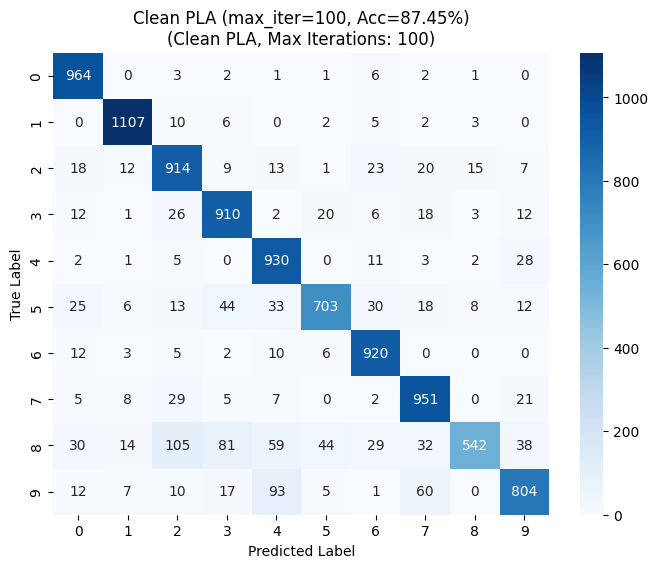

Confusions: Clean PLA:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s]

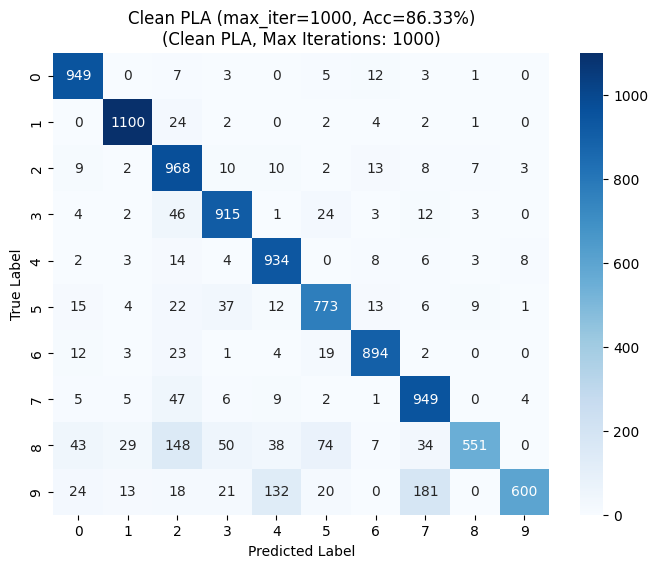

Confusions: Pocket PLA:   0%|          | 0/2 [00:00<?, ?it/s]

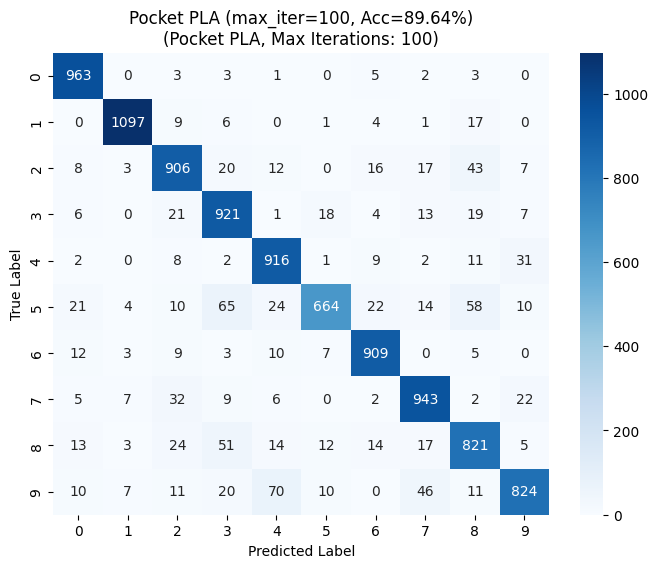

Confusions: Pocket PLA:  50%|█████     | 1/2 [00:00<00:00,  9.26it/s]

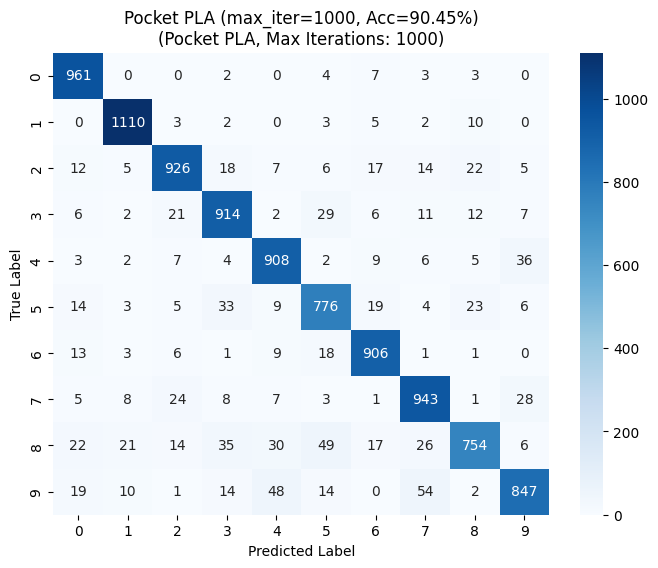

Confusions: Softmax:   0%|          | 0/2 [00:00<?, ?it/s]

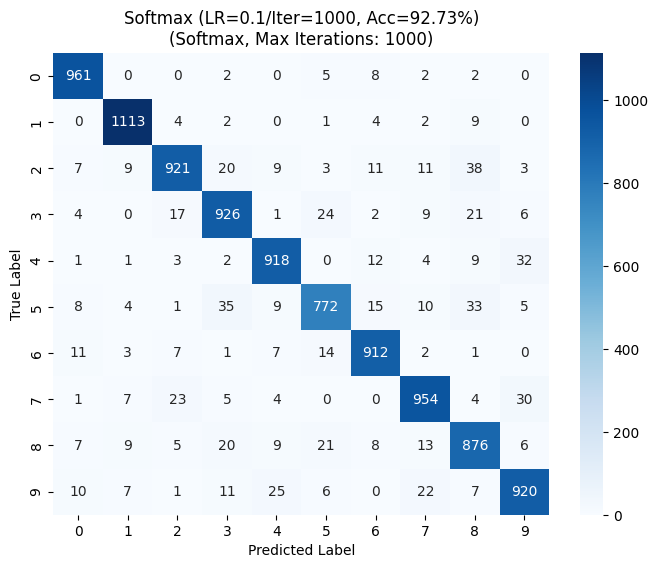

Confusions: Softmax:  50%|█████     | 1/2 [00:00<00:00,  9.26it/s]

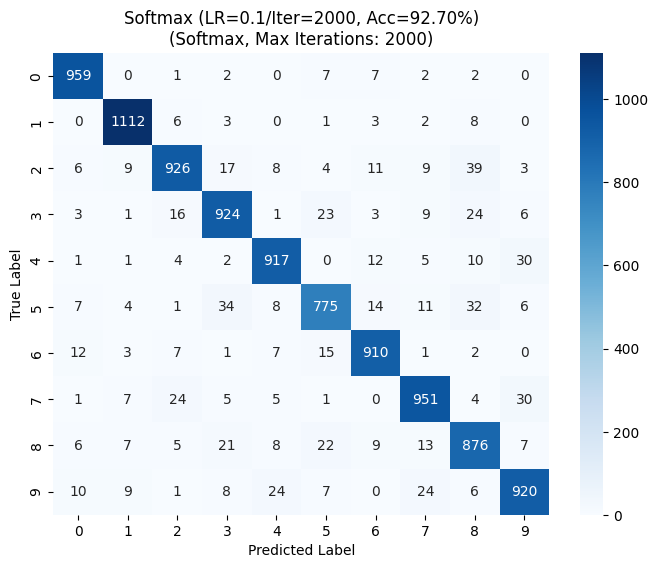

Confusions: Linear:   0%|          | 0/2 [00:00<?, ?it/s]

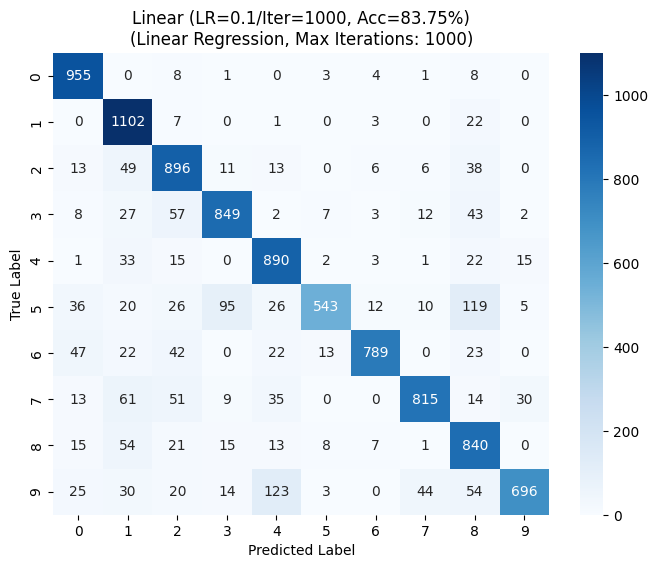

Confusions: Linear:  50%|█████     | 1/2 [00:00<00:00,  9.21it/s]

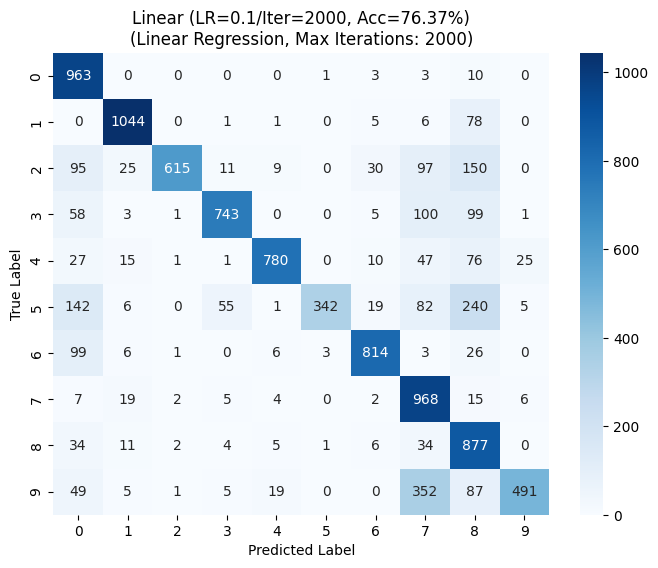

Confusions: Linear: 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]
INFO - === Iteration-Level Visualization (All Models) ===


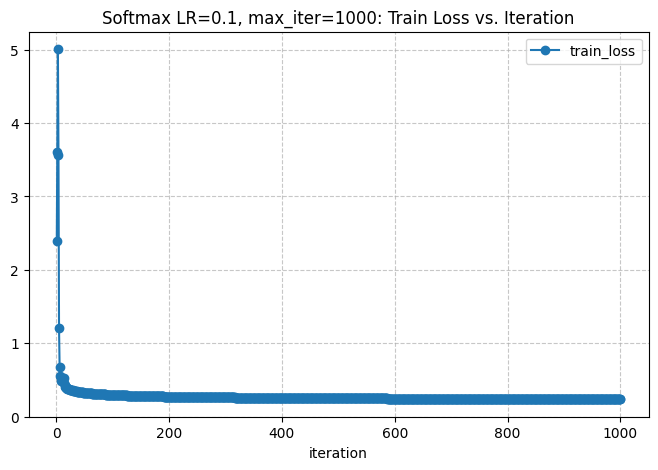

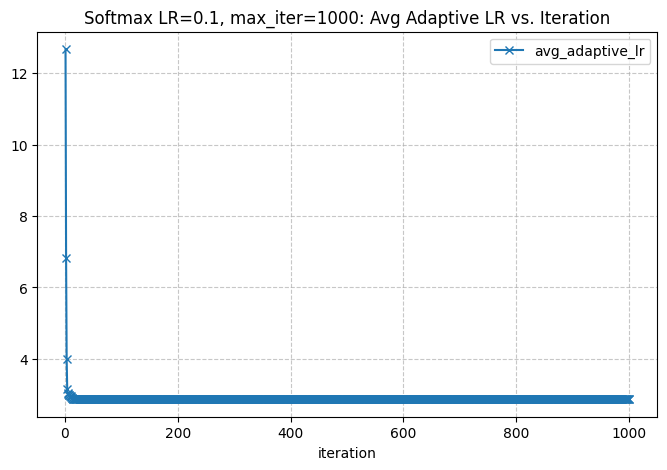

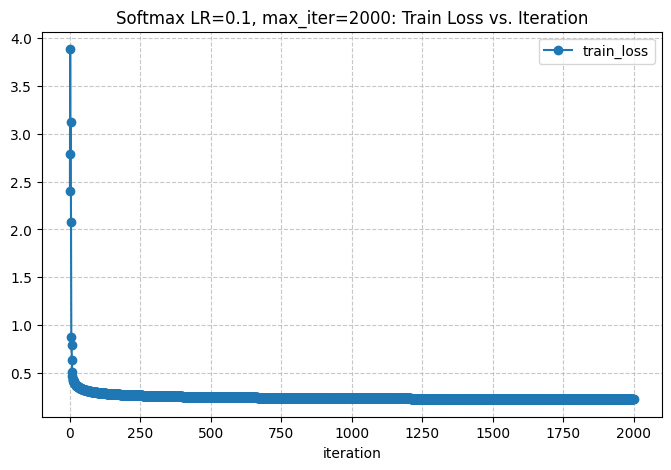

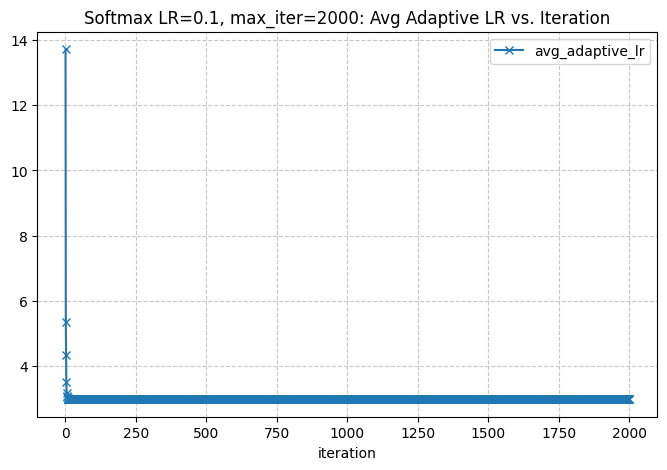

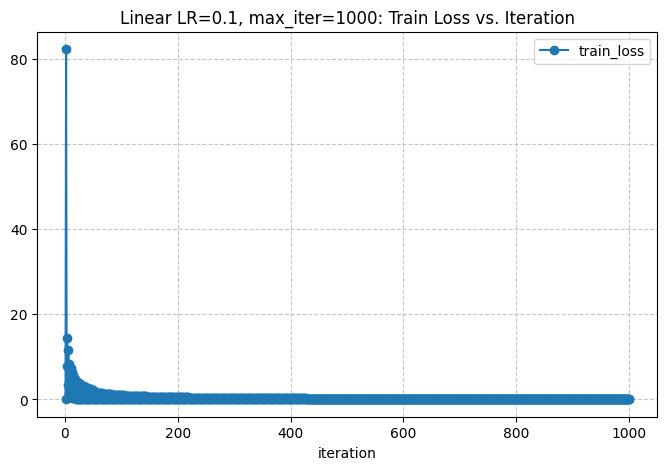

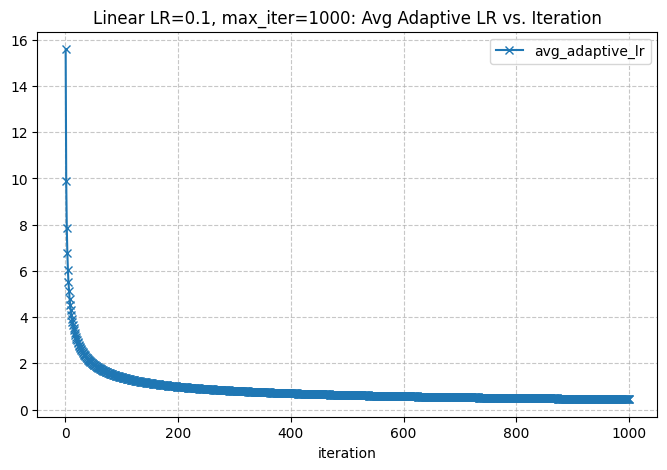

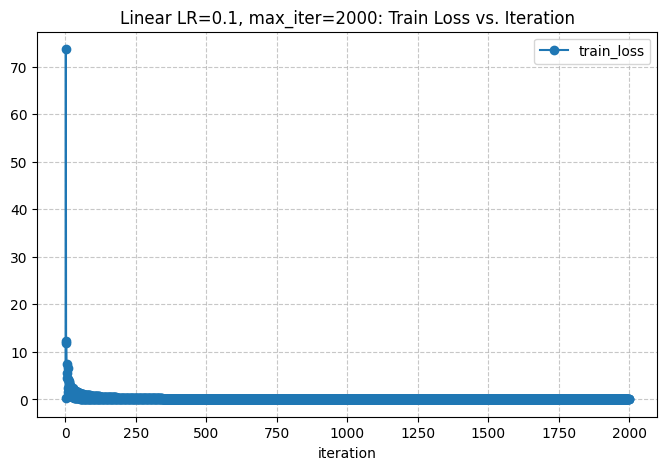

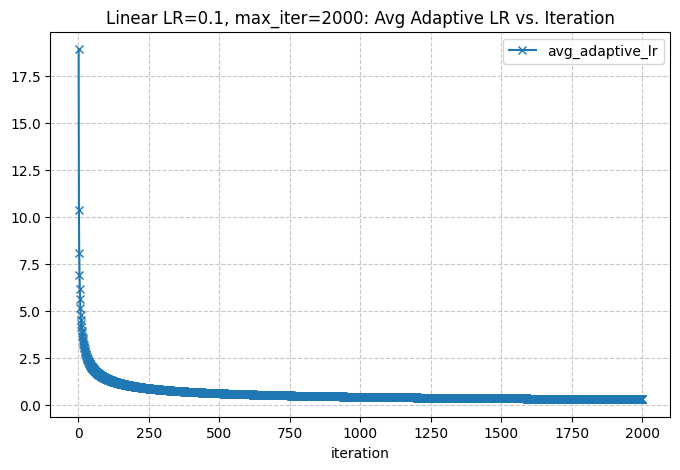

INFO - === Pandas + Seaborn Plots ===


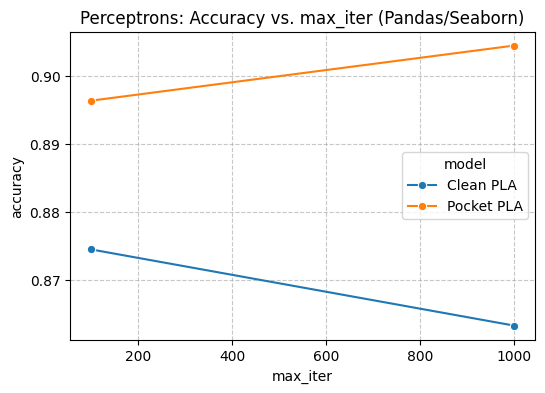

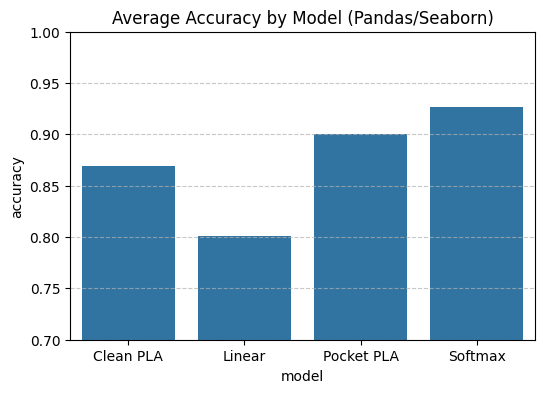

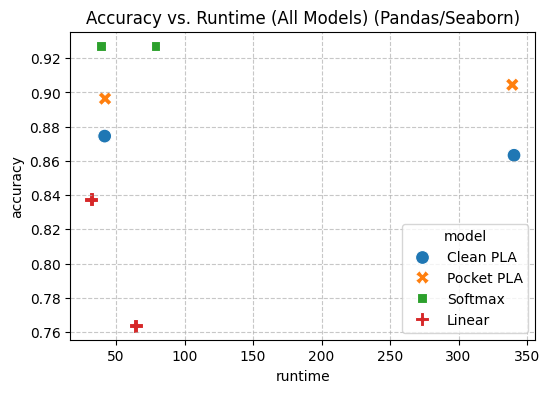

INFO - === Custom Summaries (Aggregated Curves, etc.) ===


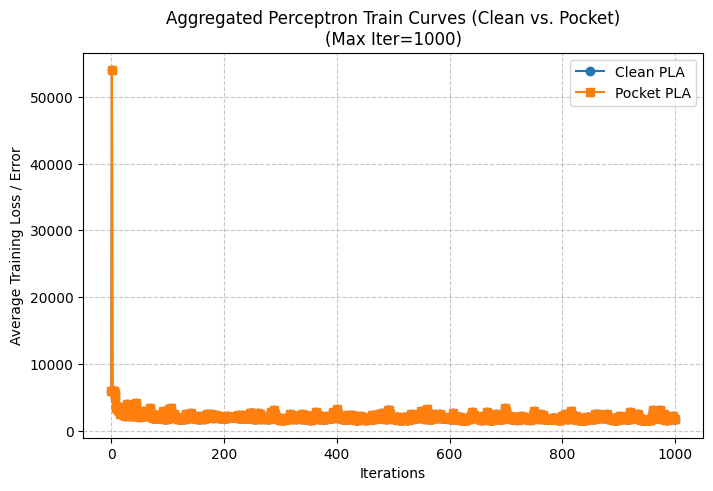

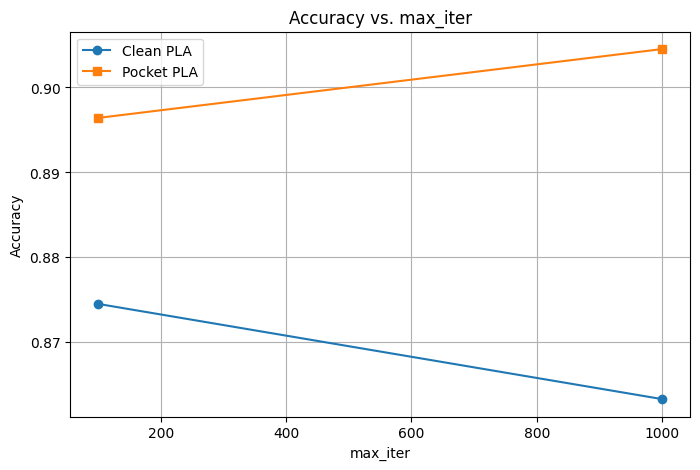

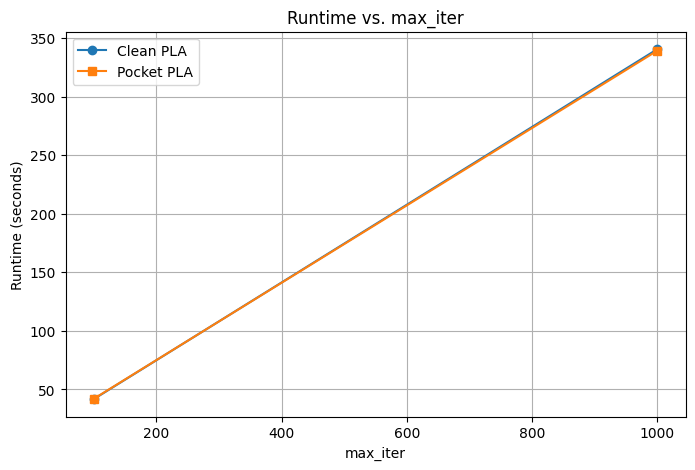

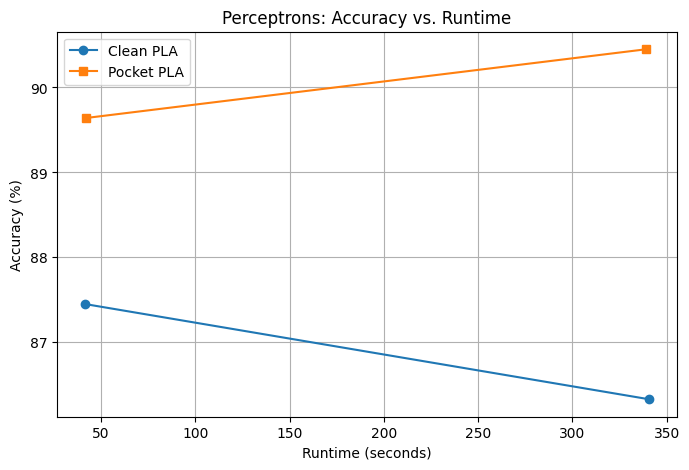

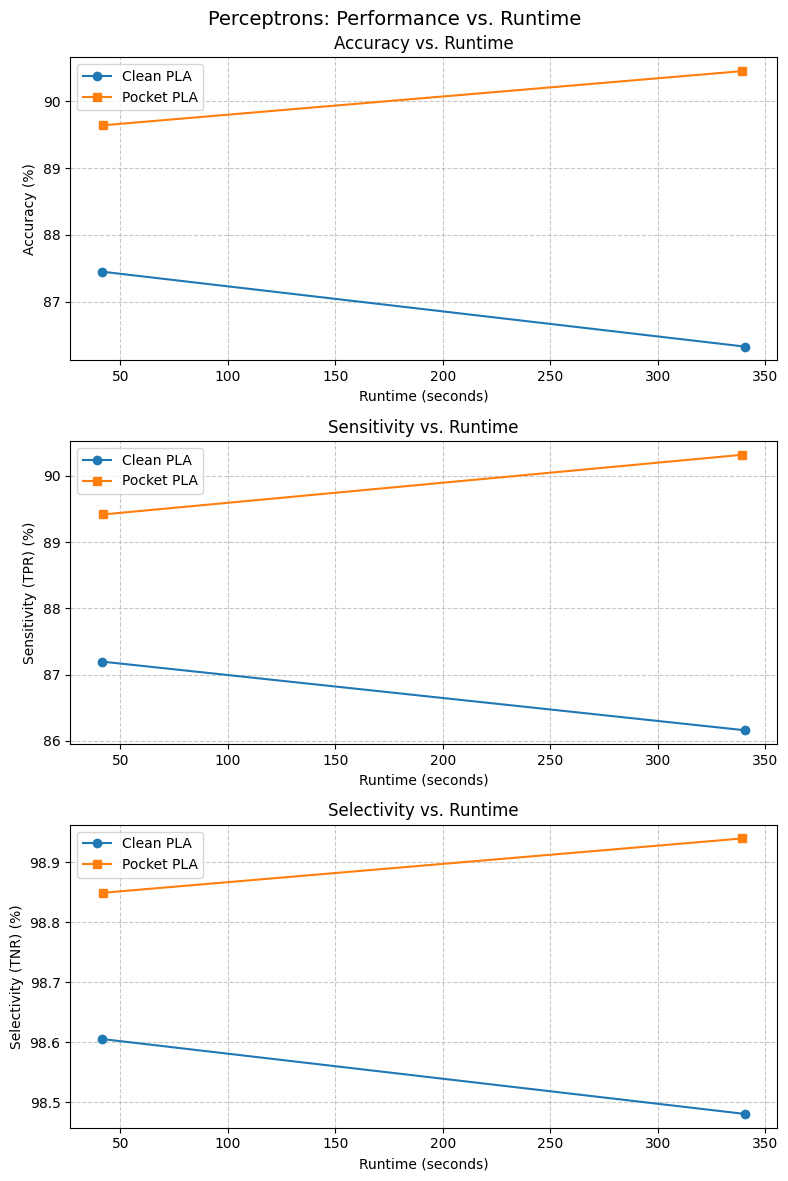

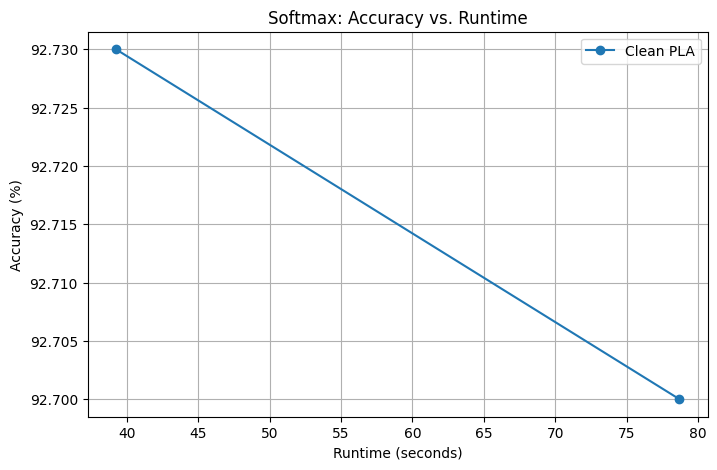

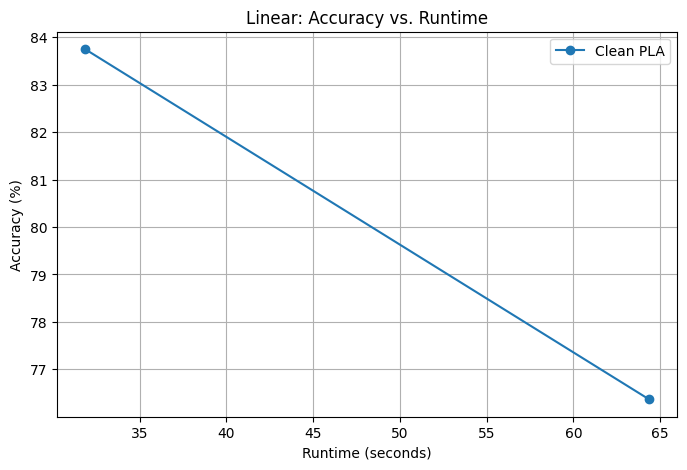

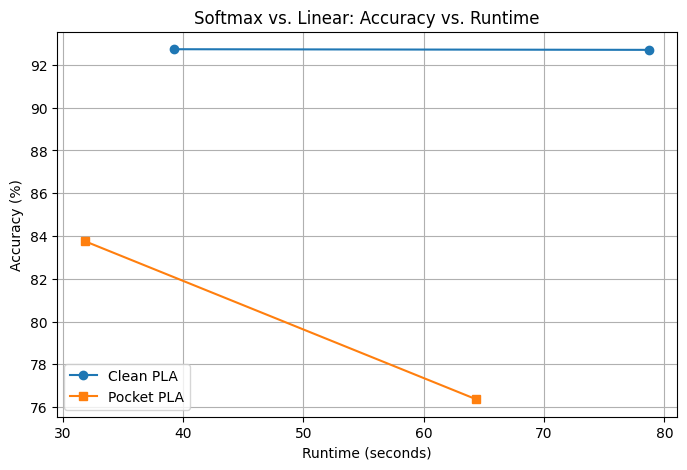

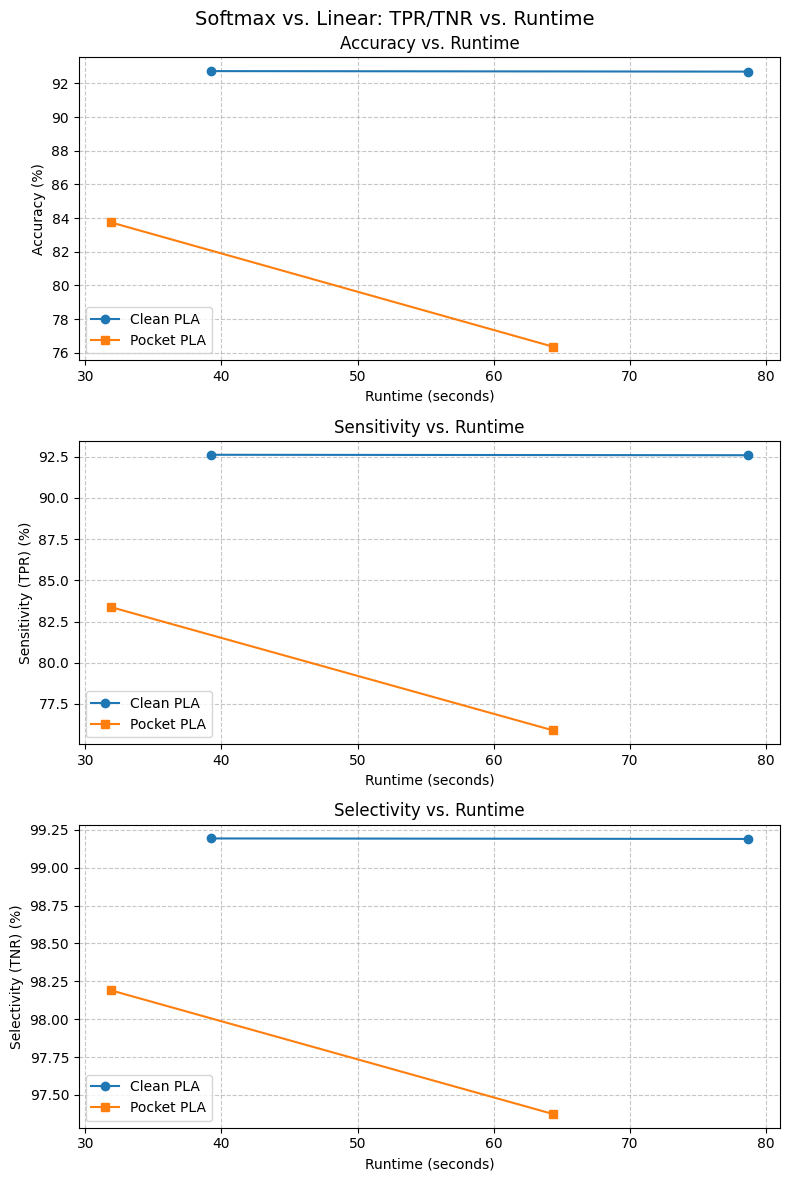

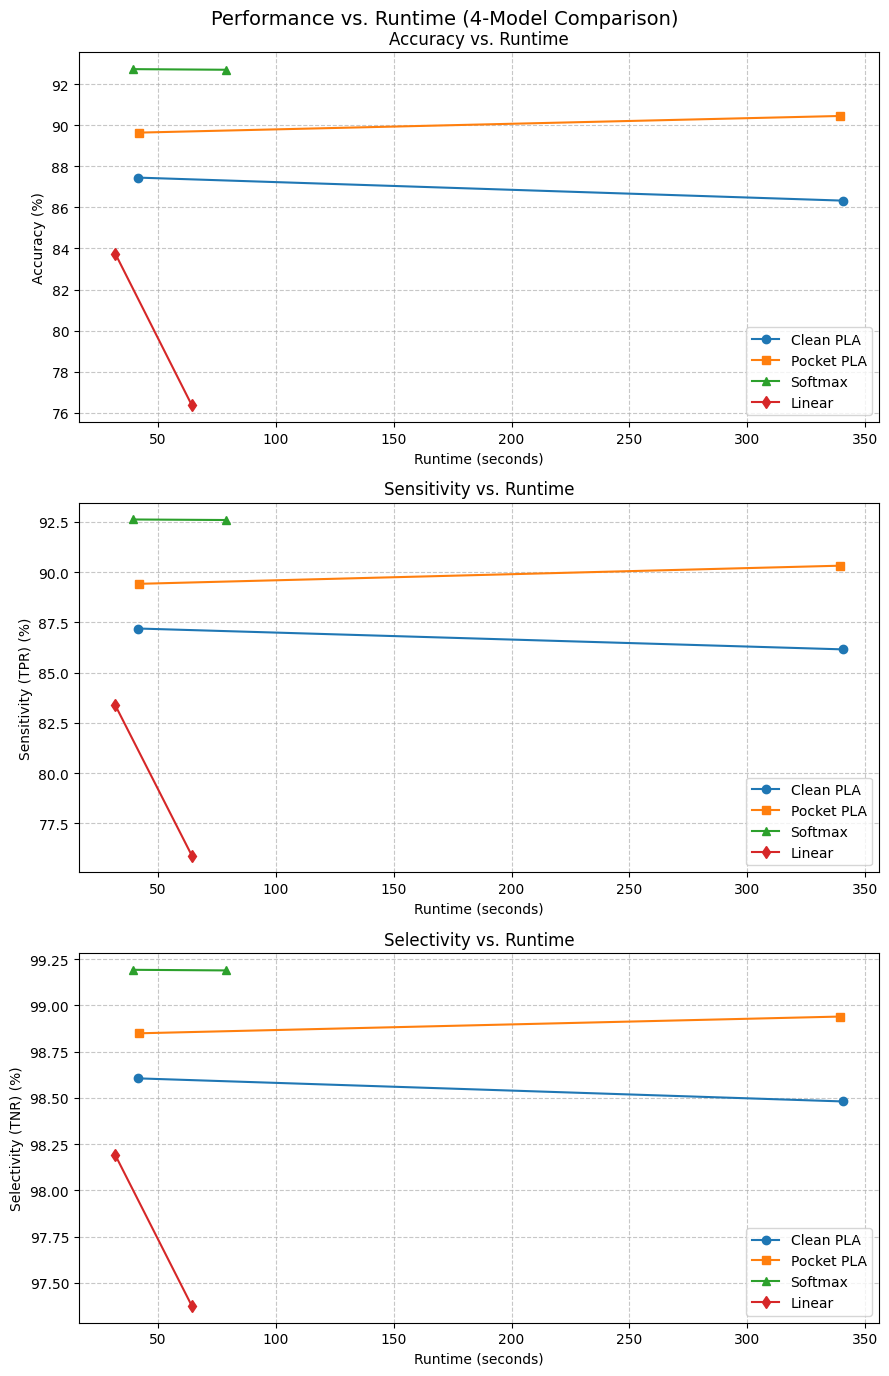

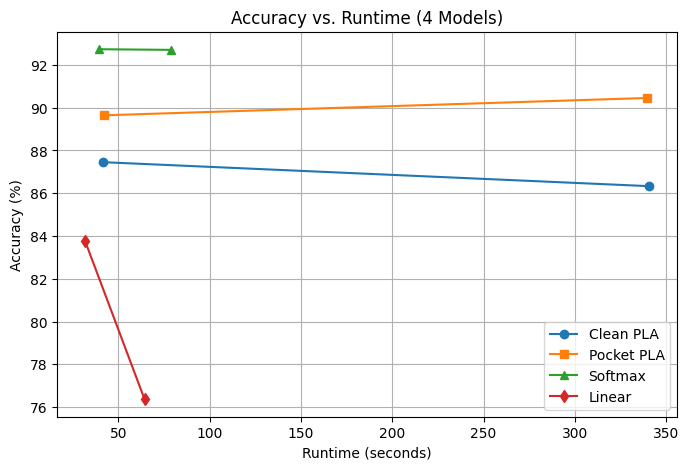

INFO - === All Visualizations Complete ===


In [8]:
##################################################
# 1) CREATE A SINGLE PANDAS DATAFRAME FOR ALL RESULTS
##################################################
all_rows = []

# (A) Clean PLA
for i, max_iter in tqdm(
    enumerate(perceptron_max_iter_values),
    desc="Collecting Clean PLA",
    total=len(perceptron_max_iter_values)
):
    all_rows.append({
        'model': 'Clean PLA',
        'max_iter': max_iter,
        'runtime': runtimes_clean[i],
        'accuracy': accuracies_clean[i],
        'sensitivity': sensitivities_clean[i],
        'selectivity': selectivities_clean[i]
    })

# (B) Pocket PLA
for i, max_iter in tqdm(
    enumerate(perceptron_max_iter_values),
    desc="Collecting Pocket PLA",
    total=len(perceptron_max_iter_values)
):
    all_rows.append({
        'model': 'Pocket PLA',
        'max_iter': max_iter,
        'runtime': runtimes_pocket[i],
        'accuracy': accuracies_pocket[i],
        'sensitivity': sensitivities_pocket[i],
        'selectivity': selectivities_pocket[i]
    })

# (C) Softmax
for i, row_meta in tqdm(
    enumerate(meta_soft),
    desc="Collecting Softmax",
    total=len(meta_soft)
):
    all_rows.append({
        'model': 'Softmax',
        'max_iter': row_meta['max_iter'],
        'runtime': runtimes_softmax[i],
        'accuracy': accuracies_softmax[i],
        'sensitivity': sensitivities_soft[i],
        'selectivity': selectivities_soft[i]
    })

# (D) Linear
for i, row_meta in tqdm(
    enumerate(meta_linear),
    desc="Collecting Linear",
    total=len(meta_linear)
):
    all_rows.append({
        'model': 'Linear',
        'max_iter': row_meta['max_iter'],
        'runtime': runtimes_linear[i],
        'accuracy': accuracies_linear[i],
        'sensitivity': sensitivities_lin[i],
        'selectivity': selectivities_lin[i]
    })

df_results = pd.DataFrame(all_rows)
logger.info("Combined Results DataFrame:\n%s", df_results)
display(df_results.head(20))

############################################################################
# 2) CONFUSION MATRICES FOR ALL MODELS (GROUPED BY PLOT TYPE)
############################################################################

logger.info("=== Plotting ALL Confusion Matrices ===")

# 2A) Perceptron: Clean
for idx, meta in tqdm(enumerate(meta_clean), total=len(meta_clean), desc="Confusions: Clean PLA"):
    title = f"Clean PLA (max_iter={meta['max_iter']}, Acc={meta['accuracy']*100:.2f}%)"
    plot_confusion_matrix_annotated(
        conf_clean[idx],
        classes=range(10),
        title=title,
        method=meta["method"],
        max_iter=meta["max_iter"]
    )

# 2B) Perceptron: Pocket
for idx, meta in tqdm(enumerate(meta_pocket), total=len(meta_pocket), desc="Confusions: Pocket PLA"):
    title = f"Pocket PLA (max_iter={meta['max_iter']}, Acc={meta['accuracy']*100:.2f}%)"
    plot_confusion_matrix_annotated(
        conf_pocket[idx],
        classes=range(10),
        title=title,
        method=meta["method"],
        max_iter=meta["max_iter"]
    )

# 2C) Softmax
for idx, meta in tqdm(enumerate(meta_soft), total=len(meta_soft), desc="Confusions: Softmax"):
    title = f"Softmax ({meta['label']}, Acc={meta['accuracy']*100:.2f}%)"
    plot_confusion_matrix_annotated(
        conf_soft[idx],
        classes=range(10),
        title=title,
        method=meta["method"],
        max_iter=meta["max_iter"]
    )

# 2D) Linear
for idx, meta in tqdm(enumerate(meta_linear), total=len(meta_linear), desc="Confusions: Linear"):
    title = f"Linear ({meta['label']}, Acc={meta['accuracy']*100:.2f}%)"
    plot_confusion_matrix_annotated(
        conf_linear[idx],
        classes=range(10),
        title=title,
        method=meta["method"],
        max_iter=meta["max_iter"]
    )


############################################################################
# 3) ITERATION-LEVEL PLOTS (ALL MODELS)
############################################################################

logger.info("=== Iteration-Level Visualization (All Models) ===")

# 3A) Perceptron: Clean & Pocket
for max_iter, c_model in trained_models_clean.items():
    df_iter = c_model.get_iteration_df()
    if not df_iter.empty and "train_error" in df_iter.columns:
        title = f"Clean PLA max_iter={max_iter}: Train Error vs. Iteration"
        df_iter.plot(x="iteration", y="train_error", marker='o', figsize=(8,5), title=title)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

for max_iter, p_model in trained_models_pocket.items():
    df_iter = p_model.get_iteration_df()
    if not df_iter.empty and "train_error" in df_iter.columns:
        title = f"Pocket PLA max_iter={max_iter}: Train Error vs. Iteration"
        df_iter.plot(x="iteration", y="train_error", marker='o', figsize=(8,5), title=title)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

# 3B) Softmax
for (lr_val, max_iter_val), s_model in trained_models_softmax.items():
    df_iter = s_model.get_iteration_df()  # Must be implemented in your SoftmaxRegression
    if not df_iter.empty:
        title = f"Softmax LR={lr_val}, max_iter={max_iter_val}: Train Loss vs. Iteration"
        df_iter.plot(x="iteration", y="train_loss", marker='o', figsize=(8,5), title=title)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

        if "test_loss" in df_iter.columns:
            title = f"Softmax LR={lr_val}, max_iter={max_iter_val}: Train & Test Loss"
            df_iter.plot(x="iteration", y=["train_loss","test_loss"], marker='o', figsize=(8,5), title=title)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.show()

        if "avg_adaptive_lr" in df_iter.columns:
            title = f"Softmax LR={lr_val}, max_iter={max_iter_val}: Avg Adaptive LR vs. Iteration"
            df_iter.plot(x="iteration", y="avg_adaptive_lr", marker='x', figsize=(8,5), title=title)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.show()

# 3C) Linear
for (lr_val, max_iter_val), lin_model in trained_models_linear.items():
    df_iter = lin_model.get_iteration_df()  # Must be implemented in your LinearRegression
    if not df_iter.empty:
        title = f"Linear LR={lr_val}, max_iter={max_iter_val}: Train Loss vs. Iteration"
        df_iter.plot(x="iteration", y="train_loss", marker='o', figsize=(8,5), title=title)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

        if "test_loss" in df_iter.columns:
            title = f"Linear LR={lr_val}, max_iter={max_iter_val}: Train & Test Loss"
            df_iter.plot(x="iteration", y=["train_loss","test_loss"], marker='o', figsize=(8,5), title=title)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.show()

        if "avg_adaptive_lr" in df_iter.columns:
            title = f"Linear LR={lr_val}, max_iter={max_iter_val}: Avg Adaptive LR vs. Iteration"
            df_iter.plot(x="iteration", y="avg_adaptive_lr", marker='x', figsize=(8,5), title=title)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.show()


############################################################################
# 4) PANDAS + SEABORN PLOTS
############################################################################

logger.info("=== Pandas + Seaborn Plots ===")

# 4A) LINE PLOT: Accuracy vs. max_iter (Perceptrons Only)
df_perc = df_results[df_results['model'].isin(['Clean PLA','Pocket PLA'])].copy()
df_perc.sort_values(['model','max_iter'], inplace=True)

plt.figure(figsize=(6,4))
sns.lineplot(
    data=df_perc,
    x='max_iter', y='accuracy',
    hue='model', marker='o'
)
plt.title("Perceptrons: Accuracy vs. max_iter (Pandas/Seaborn)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 4B) BAR CHART: Average Accuracy by Model
df_mean = df_results.groupby('model', as_index=False)['accuracy'].mean()

plt.figure(figsize=(6,4))
sns.barplot(data=df_mean, x='model', y='accuracy')
plt.title("Average Accuracy by Model (Pandas/Seaborn)")
plt.ylim(0.7, 1.0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4C) SCATTER PLOT: Accuracy vs. Runtime, colored by model
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=df_results,
    x='runtime', y='accuracy',
    hue='model', style='model',
    s=100
)
plt.title("Accuracy vs. Runtime (All Models) (Pandas/Seaborn)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


############################################################################
# 5) CUSTOM SUMMARY PLOTS (AGGREGATED CURVES, ETC.)
############################################################################

logger.info("=== Custom Summaries (Aggregated Curves, etc.) ===")

# 5A) Aggregated Perceptron Curves
plot_train_curves_three_models(
    clean_train_curve=clean_train_curve,
    pocket_train_curve=pocket_train_curve,
    softmax_train_curve=None,  # no Softmax aggregator
    title="Aggregated Perceptron Train Curves (Clean vs. Pocket)",
    max_iter=perceptron_max_iter_values[-1]
)

# 5B) Summaries for Perceptron
plot_accuracy_vs_max_iter(
    max_iter_values=perceptron_max_iter_values,
    accuracies_clean=accuracies_clean,
    accuracies_pocket=accuracies_pocket,
    accuracies_softmax=None
)

plot_runtime_vs_max_iter(
    max_iter_values=perceptron_max_iter_values,
    runtimes_clean=runtimes_clean,
    runtimes_pocket=runtimes_pocket,
    runtimes_softmax=None
)

plot_accuracy_vs_runtime(
    runtimes_clean=runtimes_clean,
    accuracies_clean=accuracies_clean,
    runtimes_pocket=runtimes_pocket,
    accuracies_pocket=accuracies_pocket,
    title="Perceptrons: Accuracy vs. Runtime"
)

plot_performance_summary_extended_by_runtime(
    runtimes_clean=runtimes_clean,
    accuracies_clean=accuracies_clean,
    sensitivities_clean=sensitivities_clean,
    selectivities_clean=selectivities_clean,
    runtimes_pocket=runtimes_pocket,
    accuracies_pocket=accuracies_pocket,
    sensitivities_pocket=sensitivities_pocket,
    selectivities_pocket=selectivities_pocket,
    title="Perceptrons: Performance vs. Runtime"
)

# 5C) Summaries for Softmax & Linear
plot_accuracy_vs_runtime(
    runtimes_clean=runtimes_softmax,
    accuracies_clean=accuracies_softmax,
    title="Softmax: Accuracy vs. Runtime"
)
plot_accuracy_vs_runtime(
    runtimes_clean=runtimes_linear,
    accuracies_clean=accuracies_linear,
    title="Linear: Accuracy vs. Runtime"
)
plot_accuracy_vs_runtime(
    runtimes_clean=runtimes_softmax,
    accuracies_clean=accuracies_softmax,
    runtimes_pocket=runtimes_linear,
    accuracies_pocket=accuracies_linear,
    title="Softmax vs. Linear: Accuracy vs. Runtime"
)
plot_performance_summary_extended_by_runtime(
    runtimes_clean=runtimes_softmax,
    accuracies_clean=accuracies_softmax,
    sensitivities_clean=sensitivities_soft,
    selectivities_clean=selectivities_soft,
    runtimes_pocket=runtimes_linear,
    accuracies_pocket=accuracies_linear,
    sensitivities_pocket=sensitivities_lin,
    selectivities_pocket=selectivities_lin,
    title="Softmax vs. Linear: TPR/TNR vs. Runtime"
)

# 5D) 4-Model Comparison
plot_performance_summary_4models_by_runtime(
    runtimes_clean, accuracies_clean, sensitivities_clean, selectivities_clean,
    runtimes_pocket, accuracies_pocket, sensitivities_pocket, selectivities_pocket,
    runtimes_softmax, accuracies_softmax, sensitivities_soft, selectivities_soft,
    runtimes_linear, accuracies_linear, sensitivities_lin, selectivities_lin,
    title="Performance vs. Runtime (4-Model Comparison)"
)

plot_accuracy_vs_runtime_4models(
    rt_clean=runtimes_clean,
    acc_clean=accuracies_clean,
    rt_pocket=runtimes_pocket,
    acc_pocket=accuracies_pocket,
    rt_softmax=runtimes_softmax,
    acc_softmax=accuracies_softmax,
    rt_linear=runtimes_linear,
    acc_linear=accuracies_linear,
    title="Accuracy vs. Runtime (4 Models)"
)

logger.info("=== All Visualizations Complete ===")
